<a href="https://colab.research.google.com/github/badhon4772/Computer-Vision-and-Deep-Learning-in-Medical-Imaging/blob/main/Image%20Preprocessing%20and%20Quality%20Analysis%20with%20Transfer%20Learning%20Model%20(ViT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Applying one or two preprocessing methods to a dataset of images

In [ ]:
import zipfile
import os

# Path to the .zip file
zip_file_path = '/content/dataset.zip'
extract_path = 'dataset'

# Extract the .zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: dataset


**CLAHE and Erosion have been applied and shown 50 images from the lung disease dataset:**

In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np

# Paths
output_path = 'lungdata'
os.makedirs(output_path, exist_ok=True)

def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def apply_erosion(image, kernel_size=(1, 1), iterations=1):
    kernel = np.ones(kernel_size, np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=iterations)
    return eroded_image

# Combined function
def preprocess_image(image):
    image_clahe = apply_clahe(image)
    image_erosion = apply_erosion(image_clahe, kernel_size=(2, 2), iterations=1)
    return image_erosion

# Base path for your images
base_image_path = os.path.join('dataset', 'Lung X-Ray Image', 'Lung X-Ray Image')

# Subfolders to process
subfolders = ['Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Iterate through subfolders
for subfolder in subfolders:
    input_path = os.path.join(base_image_path, subfolder)  # Path to images in subfolder
    output_subfolder_path = os.path.join(output_path, subfolder)  # Output path for subfolder
    os.makedirs(output_subfolder_path, exist_ok=True)  # Create output subfolder

    for filename in tqdm(os.listdir(input_path), desc=f"Processing {subfolder}"):
        image_path = os.path.join(input_path, filename)
        image = cv2.imread(image_path)

        if image is not None:
            # Apply Erosion
            final_image = apply_erosion(image)
            # Save the final processed image
            cv2.imwrite(os.path.join(output_subfolder_path, filename), final_image)
        else:
            print(f"Error: Could not load image from {image_path}")


Processing Viral Pneumonia: 100%|██████████| 1100/1100 [00:01<00:00, 958.12it/s]


Visualizing images after preprocessing:

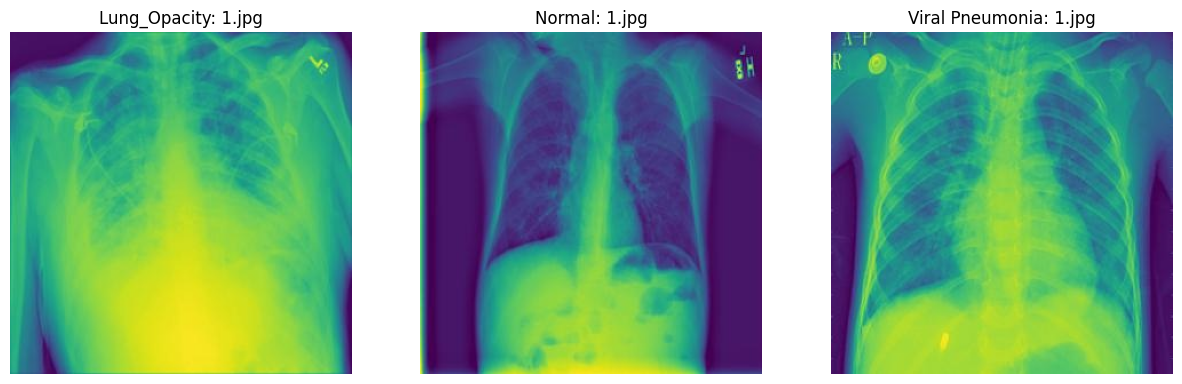

In [ ]:
import matplotlib.pyplot as plt

# Paths
base_image_path = 'lungdata'
subfolders = ['Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Iterate through subfolders and plot one image from each
for i, subfolder in enumerate(subfolders):
    input_path = os.path.join(base_image_path, subfolder)

    # Get a list of image files and sort them
    image_files = [f.path for f in os.scandir(input_path) if f.is_file()]
    image_files.sort()

    # Get the first image file (after sorting)
    image_file = image_files[0]
    image_name = os.path.basename(image_file)  # Get the image file name

    # Read and display the image
    image = cv2.imread(image_file)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    axes[i].imshow(image_rgb)
    axes[i].set_title(subfolder)
    axes[i].set_title(f"{subfolder}: {image_name}")  # Include image name in title
    axes[i].axis('off')  # Turn off axis ticks and labels

plt.show()

##2. Extract the PSNR, SSIM, MSE, and RMSE values for each image, save the values in a DataFrame, and export it as a CSV file.

In [ ]:
import os
import cv2
import numpy as np
from skimage import metrics
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from tqdm import tqdm

# Define paths
dataset_path = "/content/dataset/Lung X-Ray Image/Lung X-Ray Image"  # Path to original dataset
lungdata_path = "/content/lungdata"  # Path to processed dataset
subfolders = ['Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Initialize list to store results
results = []

# Function to compute metrics
def compute_metrics(ref_img, img):
    mse = metrics.mean_squared_error(ref_img, img)
    psnr = metrics.peak_signal_noise_ratio(ref_img, img, data_range=255)
    ssim_value = ssim(ref_img, img, data_range=img.max() - img.min(), channel_axis=2)
    rmse = np.sqrt(mse)
    return mse, psnr, ssim_value, rmse

# Iterate through each subfolder
for subfolder in subfolders:
    original_folder = os.path.join(dataset_path, subfolder)
    processed_folder = os.path.join(lungdata_path, subfolder)

    # Iterate through each image in the subfolder
    for filename in tqdm(os.listdir(original_folder), desc=f"Processing {subfolder}"):
        original_image_path = os.path.join(original_folder, filename)
        processed_image_path = os.path.join(processed_folder, filename)

        # Check if both images exist
        if os.path.exists(original_image_path) and os.path.exists(processed_image_path):
            # Load images
            ref_img = cv2.imread(original_image_path)
            img = cv2.imread(processed_image_path)

            # Ensure the images are the same size
            if ref_img.shape == img.shape:
                # Compute metrics
                mse, psnr, ssim_value, rmse = compute_metrics(ref_img, img)

                # Append results
                results.append({
                    "Subfolder": subfolder,
                    "Filename": filename,
                    "MSE": mse,
                    "PSNR": psnr,
                    "SSIM": ssim_value,
                    "RMSE": rmse
                })
            else:
                print(f"Skipping {filename} due to mismatched dimensions.")
        else:
            print(f"Missing file: {filename}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to a CSV file
output_csv_path = "/content/image_quality_metrics.csv"
results_df.to_csv(output_csv_path, index=False)

print(f"Metrics saved to: {output_csv_path}")


Processing Viral Pneumonia: 100%|██████████| 1100/1100 [00:38<00:00, 28.29it/s]


Metrics saved to: /content/image_quality_metrics.csv


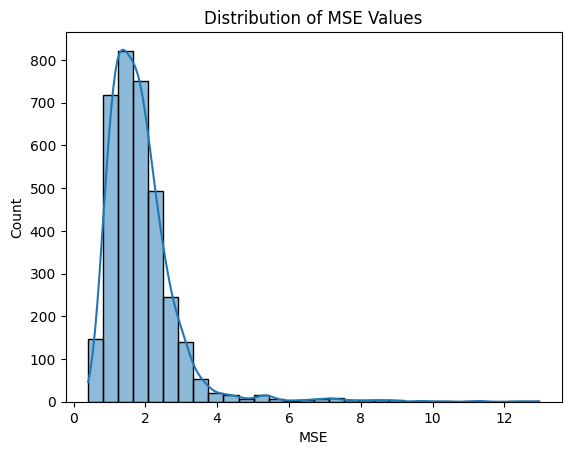

In [ ]:
import seaborn as sns
sns.histplot(results_df['MSE'], bins=30, kde=True)
plt.title("Distribution of MSE Values")
plt.show()

##3. Use the preprocessed dataset to train a transfer learning model and extract overall performance analysis metrics.

In [ ]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
folder = "/content/lungdata"
for folder_name in os.listdir(folder):
    folder_path = os.path.join(folder, folder_name)

    if os.path.isdir(folder_path):
        _, _, files = next(os.walk(folder_path))
        file_count = len(files)
        print(f"Folder '{folder_name}' contains {file_count} files.")

Folder 'Lung_Opacity' contains 1125 files.
Folder 'Viral Pneumonia' contains 1100 files.
Folder 'Normal' contains 1250 files.


In [ ]:
import random
from PIL import Image

for folder_name in os.listdir(folder):
    folder_path = os.path.join(folder, folder_name)

    if os.path.isdir(folder_path):
        _, _, files = next(os.walk(folder_path))

        # Select a random image file
        if files:
            random_file = random.choice(files)
            image_path = os.path.join(folder_path, random_file)

            with Image.open(image_path) as img:
                print(f"Folder '{folder_name}':")
                print(f"  Random Image: {random_file}")
                print(f"  Image Size: {img.size}")

Folder 'Lung_Opacity':
  Random Image: 452.jpg
  Image Size: (299, 299)
Folder 'Viral Pneumonia':
  Random Image: 83.jpg
  Image Size: (299, 299)
Folder 'Normal':
  Random Image: 257.jpg
  Image Size: (299, 299)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

Resizing the image shape into 64x64

In [ ]:
img_size = 64
labels = ['Lung_Opacity', 'Normal', 'Viral Pneumonia']

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]  # Convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

train = get_data("/content/lungdata")

# Verify the data
print(f"Total samples: {len(train)}")
print(f"Shape of first image: {train[0][0].shape}")
print(f"Label of first image: {train[0][1]}")

Total samples: 3475
Shape of first image: (64, 64, 3)
Label of first image: 0


<Axes: xlabel='count'>

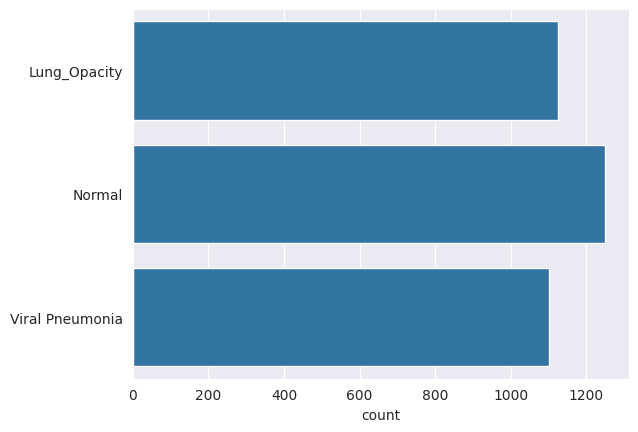

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Lung_Opacity")  # Class 0 corresponds to Lung_Opacity
    elif(i[1] == 1):
        l.append("Normal")       # Class 1 corresponds to Normal
    elif(i[1] == 2):
        l.append("Viral Pneumonia") # Class 2 corresponds to Viral Pneumonia

sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'Lung_Opacity')

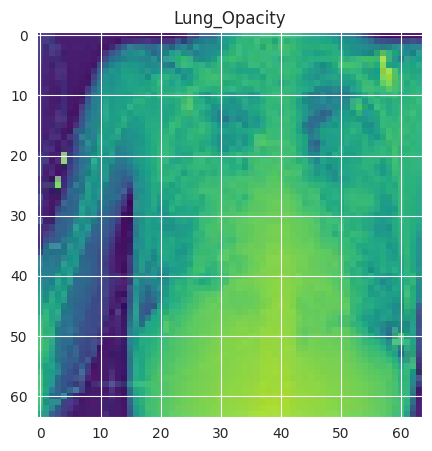

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[1][1]])

In [ ]:
x_train = []
y_train = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)
x_train = np.array(x_train) / 255
#x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

In [ ]:
print(x_train.shape)

(3475, 64, 64, 3)


In [ ]:
# split with a stratified sampling
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(x_train, y_train,
    test_size=0.15, stratify=y_train, random_state=42)

In [ ]:
#!pip install -U tensorflow-addons

In [ ]:
#!pip install --upgrade tensorflow==2.13

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
num_classes = 3
input_shape = (64, 64, 3)

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (2953, 64, 64, 3) - y_train shape: (2953,)
x_test shape: (522, 64, 64, 3) - y_test shape: (522,)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 64  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 64 X 64
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 768


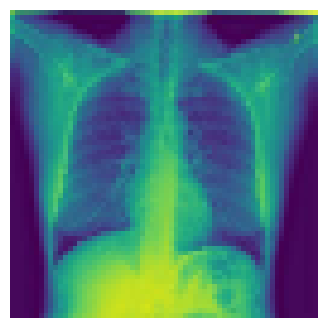

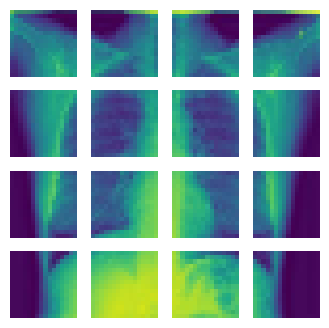

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("float"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("float"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/100
20/20 [==============================] - 7s 213ms/step - loss: 1.1749 - accuracy: 0.6442 - top-5-accuracy: 1.0000 - val_loss: 0.4252 - val_accuracy: 0.8126 - val_top-5-accuracy: 1.0000
Epoch 2/100
20/20 [==============================] - 4s 186ms/step - loss: 0.5721 - accuracy: 0.7741 - top-5-accuracy: 1.0000 - val_loss: 0.3898 - val_accuracy: 0.8420 - val_top-5-accuracy: 1.0000
Epoch 3/100
20/20 [==============================] - 5s 232ms/step - loss: 0.5402 - accuracy: 0.7817 - top-5-accuracy: 1.0000 - val_loss: 0.3730 - val_accuracy: 0.8420 - val_top-5-accuracy: 1.0000
Epoch 4/100
20/20 [==============================] - 4s 185ms/step - loss: 0.4913 - accuracy: 0.7904 - top-5-accuracy: 1.0000 - val_loss: 0.3446 - val_accuracy: 0.8600 - val_top-5-accuracy: 1.0000
Epoch 5/100
20/20 [==============================] - 4s 193ms/step - loss: 0.4790 - accuracy: 0.8000 - top-5-accuracy: 1.0000 - val_loss: 0.3414 - val_accuracy: 0.8533 - val_top-5-accuracy: 1.0000
Epoch 6/100
20/

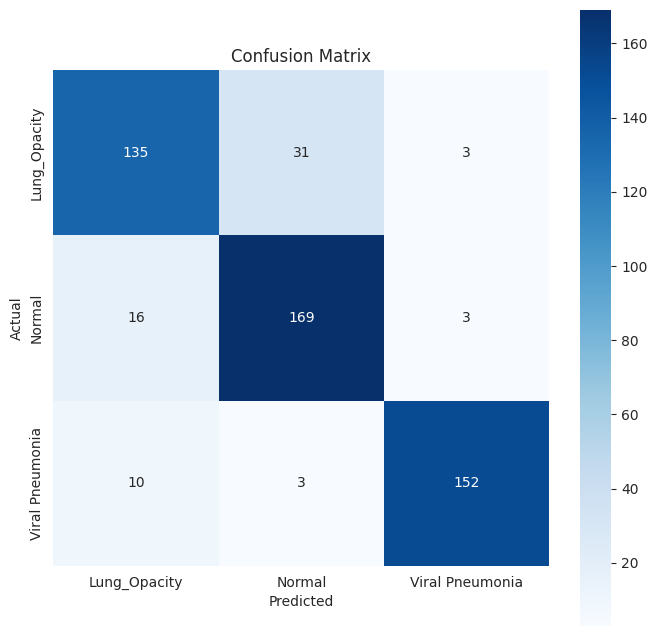

In [ ]:
import pandas as pd
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/model.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.15,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    target_names = ['Lung_Opacity', 'Normal', 'Viral Pneumonia']

    # get predict prob and label
    ypred = model.predict(x_test, verbose=1)
    ypred = np.argmax(ypred, axis=1)
    print(classification_report(y_test, ypred, target_names=target_names))

    cm = confusion_matrix(y_test, ypred)
    cm = pd.DataFrame(cm, range(3), range(3))  # Adjusted for 2 classes
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    return history

# Create your model (ensure this function is defined properly in your code)
vit_classifier = create_vit_classifier()

# Run the experiment
history = run_experiment(vit_classifier)

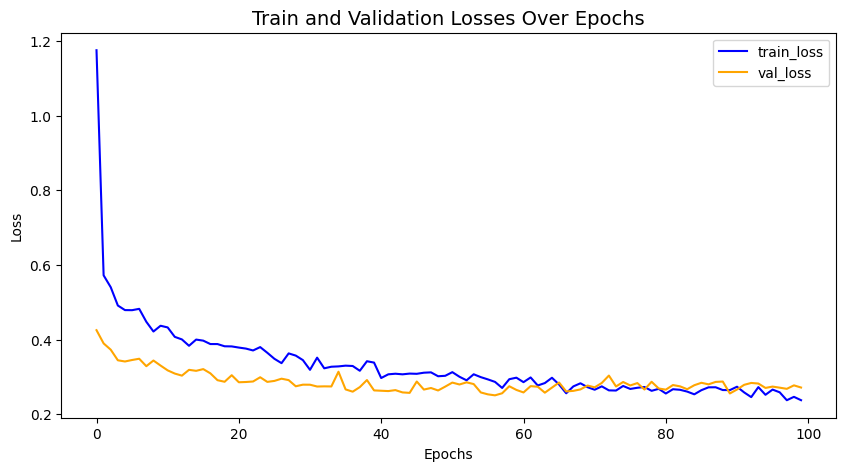

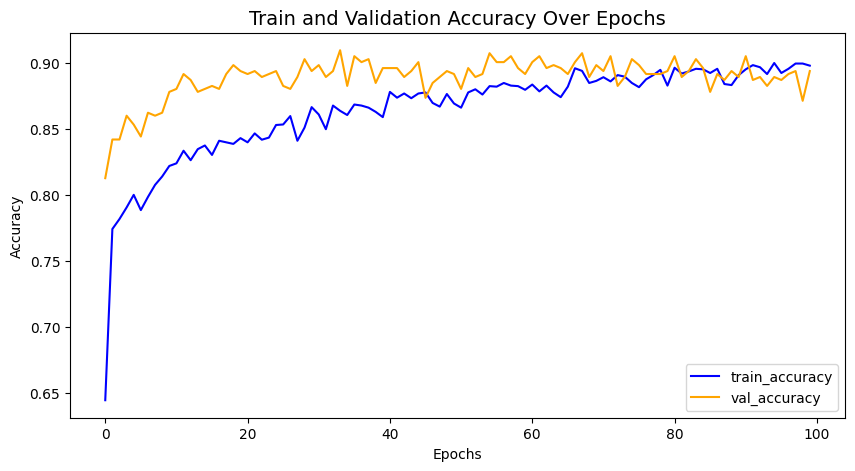

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Plot training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history.history["loss"], label="train_loss", color='blue')
plt.plot(history.history["val_loss"], label="val_loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()

plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

plt.plot(history.history["accuracy"], label="train_accuracy", color='blue')
plt.plot(history.history["val_accuracy"], label="val_accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()

plt.show()